In [2]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import statsmodels.api as sm

In [3]:
def partition(lst, size):
    for i in range(0, len(lst), size):
        yield lst[i : i+size]


In [4]:
# def acorr(data):
#     mean = np.mean(data)
#     var = np.var(data)
#     acorr = np.correlate(data, data, "full")[len(data)-1:]
#     # acorr = acorr/var/len(syllable_0)
#     return acorr

In [130]:
def get_first_strong_peak(x, label=None, graph=False):
    acorr = sm.tsa.acf(x, nlags=2000)
    peaks = find_peaks(acorr)[0]
    
    if graph:
        plt.plot(acorr, label=label)
        L = plt.legend()
        plt.setp(L.texts, family='TakaoMincho')
    
    peaks = [peak for peak in peaks if peak > 20] # filter out low offest (high frequency) peaks
    if not peaks:
        return -1, 0
    max_peak = max(peaks, key=lambda p: acorr[p])
    return max_peak, acorr[max_peak]

    for peak in peaks:
        if peak < 20:
            continue # bandaid for very low offset peaks (super high frequency)
        if acorr[peak] > 0.5:
            return peak, acorr[peak]
    return(-1, 0)

def get_syllables_naive(data, n_syll):
    return list((partition(data, len(data)//n_syll), "?", 0))[:n_syll]

def get_pitches(syllables, sample_rate):
    strong_peaks = [get_first_strong_peak(syll, f"{kana} syllable {i}")
        for i, (syll, kana, _) in enumerate(syllables)]
    base_pitches = [sample_rate / peak if peak > 0 else None
        for peak, _ in strong_peaks]
    final_pitches = [round(pitch, 1) if pitch is not None and 50 < pitch < 500
        else None for pitch in base_pitches]
    return final_pitches

In [141]:
import os
import librosa
import soundfile
from pyjuliusalign import alignFromTextgrid
from praatio import tgio

os.environ["LD_LIBRARY_PATH"] = "/usr/local/lib"

kana_to_phones = {
    "た": "t",
    "べ": "b",
    "ま": "m",
    "す": "s",
    "ん": "N",
    "き": "k",
    "し": "sh",
    "う": "u",
}

def align_onsets_kana(onsets, kana):
    i = 0
    j = 0
    kana_offsets = []
    while i < len(kana):
        if kana[i] == "ょ":
            time, old_kana = kana_offsets[-1]
            kana_offsets[-1] = (time, old_kana + "ょ")
            if kana[i+1] == "う":
                while onsets[j][1] != "o:":
                    j += 1
                kana_offsets.append((onsets[j][0], "う"))
                i += 2
            else: #not sure if this works
                while onsets[j][1] != "o":
                    j += 1
                i += 1
        else:
            onset_ipa = kana_to_phones[kana[i]]
            while not onsets[j][1].startswith(onset_ipa):
                j += 1
            kana_offsets.append((onsets[j][0], kana[i]))
            i += 1
    kana_offsets.append((onsets[-1][0], "$")) # silence at end
    return kana_offsets

def get_syllables_julius(data_stereo, sample_rate, kana):
    data_mono = librosa.to_mono(data_stereo)
    soundfile.write("align/word.wav", data_mono, sample_rate)

    with open("align/word.txt", "w") as f:
        f.write(f"0.0,{len(data_mono)/sample_rate},{kana}")
    
    soxPath = "/usr/bin/sox"
    cabochaPath = "/usr/local/bin/cabocha"
    perlPath = "/usr/bin/perl"
    juliusScriptPath = "/home/murtaza/segmentation-kit/segment_julius.pl"

    alignFromTextgrid.convertCorpusToKanaAndRomaji(
        inputPath="align",
        outputPath="align/cabocha_out",
        cabochaEncoding="utf-8",
        cabochaPath=cabochaPath,
        encoding="utf-8",
    )
    alignFromTextgrid.forceAlignCorpus(
        wavPath="align",
        txtPath="align/cabocha_out/",
        outputPath="align/output",
        juliusScriptPath=juliusScriptPath,
        soxPath=soxPath,
        perlPath=perlPath,
    )

    tg = tgio.openTextgrid("align/output/word.TextGrid")
    alignment = tg.tierDict["phones_word"].entryList
    onsets = [(interval.start, interval.label) for interval in alignment[1:-1]]
    kana_onsets = align_onsets_kana(onsets, kana)
    
    for i in range(len(kana_onsets) - 1):
        start_t, end_t = kana_onsets[i][0], kana_onsets[i+1][0]
        start_s, end_s = round(start_t * sample_rate), round(end_t * sample_rate)
        chunk = data_mono[start_s:end_s]
        yield chunk, kana_onsets[i][1], start_t

def get_syllables_start_end_julius(data_stereo, sample_rate, kana):
    data_mono = librosa.to_mono(data_stereo)
    soundfile.write("align/word.wav", data_mono, sample_rate)

    with open("align/word.txt", "w") as f:
        f.write(f"0.0,{len(data_mono)/sample_rate},{kana}")
    
    soxPath = "/usr/bin/sox"
    cabochaPath = "/usr/local/bin/cabocha"
    perlPath = "/usr/bin/perl"
    juliusScriptPath = "/home/murtaza/segmentation-kit/segment_julius.pl"

    alignFromTextgrid.convertCorpusToKanaAndRomaji(
        inputPath="align",
        outputPath="align/cabocha_out",
        cabochaEncoding="utf-8",
        cabochaPath=cabochaPath,
        encoding="utf-8",
    )
    alignFromTextgrid.forceAlignCorpus(
        wavPath="align",
        txtPath="align/cabocha_out/",
        outputPath="align/output",
        juliusScriptPath=juliusScriptPath,
        soxPath=soxPath,
        perlPath=perlPath,
    )

    tg = tgio.openTextgrid("align/output/word.TextGrid")
    alignment = tg.tierDict["phones_word"].entryList
    onsets = [(interval.start, interval.label) for interval in alignment[1:-1]]
    kana_onsets = align_onsets_kana(onsets, kana)
    
    for i in range(len(kana_onsets) - 1):
        start_t, end_t = kana_onsets[i][0], kana_onsets[i+1][0]
        start_s, end_s = round(start_t * sample_rate), round(end_t * sample_rate)
        yield kana_onsets[i][1], start_s, end_s

In [92]:
wav_path = "./audio/Pages/Masu/1_Affirmative/13_勉強します_べんきょうします_to study_0_L2.wav"
kana = "べんきょうします"
data, sr = librosa.load(wav_path, mono=False)
sylls = list(get_syllables_julius(data, sr, kana))
pitches = get_pitches(sylls, sr)



Number of transcripts converted: 1
Number of unnamed entities: 0
Number of unidentified utterances: 0
Number of words processed without error: 2
/usr/bin/perl /home/murtaza/segmentation-kit/segment_julius.pl /home/murtaza/yale/koutei/align/align_tmp
1 intervals of 1 total intervals (100.00%) and 2 phones of 2 total phones (100.00%) successfully aligned for word
====Summary====
1 intervals of 1 total intervals (100.00%) and 2 phones of 2 total phones (100.00%) successfully aligned


enter filename->.................................................................................................................enter filename->1 files processed


(108, 0.3753585740551068)

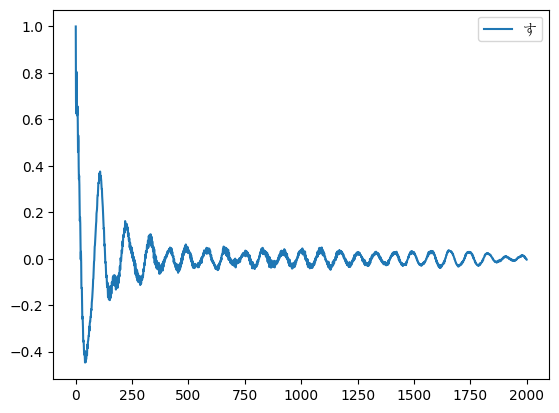

In [95]:
chunk, kana, _ = sylls[6]
get_first_strong_peak(chunk, kana, graph=True)

[0.0725, 0.1825, 0.3325, 0.4325, 0.5425, 0.7125, 0.8725]


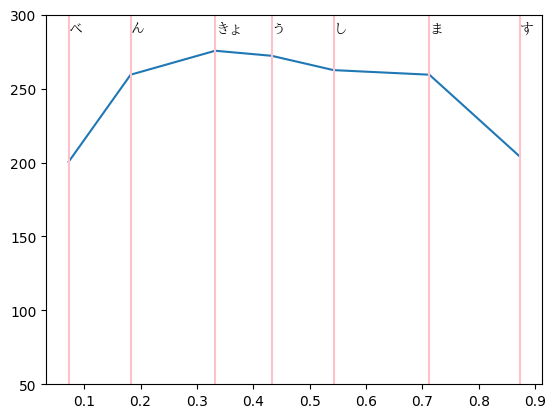

In [93]:
onsets = [syll[2] for syll in sylls]
kana = [syll[1] for syll in sylls]
print(onsets)

fig, ax = plt.subplots()

ax.plot(onsets, pitches)
ax.set_ylim(50, 300)

for onset, kana in zip(onsets, kana):
    ax.axvline(
        onset,
        -1, 1,
        color="pink",
    )
    ax.text(
        onset,
        0.95,
        kana,
        transform=ax.get_xaxis_transform(),
        fontname="TakaoMincho"
    )

/home/murtaza/.pyenv/versions/3.10.7/envs/koutei/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
enter filename->.................................................................................................................enter filename->1 files processed




Number of transcripts converted: 1
Number of unnamed entities: 0
Number of unidentified utterances: 0
Number of words processed without error: 2
/usr/bin/perl /home/murtaza/segmentation-kit/segment_julius.pl /home/murtaza/yale/koutei/align/align_tmp
1 intervals of 1 total intervals (100.00%) and 2 phones of 2 total phones (100.00%) successfully aligned for word
====Summary====
1 intervals of 1 total intervals (100.00%) and 2 phones of 2 total phones (100.00%) successfully aligned
べ 206.77200000000005
ん 267.1833333333333
きょ 278.4124999999999
う 273.4791666666667
し 260.9133333333333
ま 261.04571428571427
す 182.21249999999998


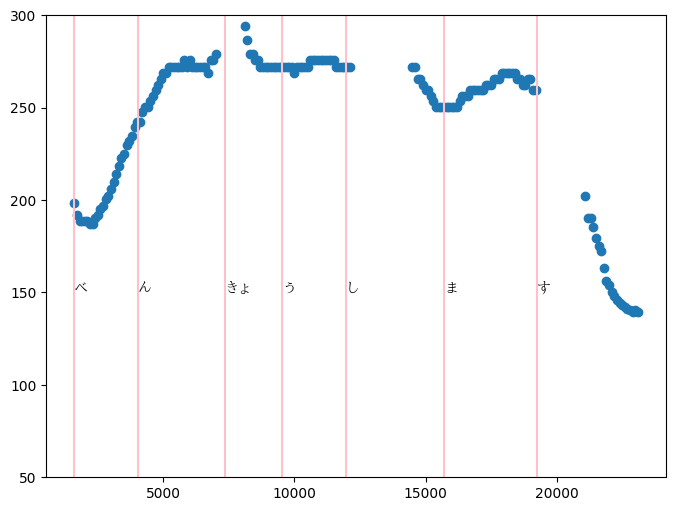

In [146]:

wav_path = "./audio/Pages/Masu/1_Affirmative/13_勉強します_べんきょうします_to study_0_L2.wav"
kana = "べんきょうします"
data, sr = librosa.load(wav_path)

INTERVAL_SAMPLES = 100
WINDOW_SAMPLES = 800
def get_pitches_fine_grained(data, sample_rate):
    for chunk_start in range(0, len(data), INTERVAL_SAMPLES):
        chunk = data[chunk_start:chunk_start+WINDOW_SAMPLES]
        strong_peak, acorr = get_first_strong_peak(chunk)
        if strong_peak > 20 \
                and 50 < sample_rate / strong_peak < 500 \
                and acorr > 0.5:
            yield chunk_start, round(sample_rate / strong_peak, 1)


fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

onsets_and_pitches = list(get_pitches_fine_grained(data, sr))
pitch_sample_onsets, pitches = zip(*onsets_and_pitches)

ax.scatter(pitch_sample_onsets, pitches)

sylls = list(get_syllables_start_end_julius(data, sr, kana))
syll_onsets = [syll[1] for syll in sylls]
syll_kana = [syll[0] for syll in sylls]

ax.set_ylim(50, 300)

for onset, kana in zip(syll_onsets, syll_kana):
    ax.axvline(
        onset,
        -1, 1,
        color="pink",
    )
    ax.text(
        onset,
        0.4,
        kana,
        transform=ax.get_xaxis_transform(),
        fontname="TakaoMincho"
    )

i = 0 
# start at beginning of first syllable
while onsets_and_pitches[i][0] < sylls[0][1]:
    i += 1

for kana, syll_s, syll_e in sylls:
    pitches = []
    while onsets_and_pitches[i][0] < syll_e:
        pitches.append(onsets_and_pitches[i][1])
        i += 1
    avg_pitch = sum(pitches) / len(pitches)
    print(kana, avg_pitch)



In [148]:

def get_avg_syllable_pitches(wav_path, kana):
    data, sr = librosa.load(wav_path)
    onsets_and_pitches = list(get_pitches_fine_grained(data, sr))
    sylls = list(get_syllables_start_end_julius(data, sr, kana))

    i = 0 
    # start at beginning of first syllable
    while onsets_and_pitches[i][0] < sylls[0][1]:
        i += 1
    avg_pitches = []
    for kana, syll_s, syll_e in sylls:
        pitches = []
        while onsets_and_pitches[i][0] < syll_e:
            pitches.append(onsets_and_pitches[i][1])
            i += 1
        avg_pitch = sum(pitches) / len(pitches)
        avg_pitches.append((kana, avg_pitch))
    return avg_pitches

wav_path = "./audio/Pages/Masu/1_Affirmative/13_勉強します_べんきょうします_to study_0_L2.wav"
kana = "べんきょうします"
get_avg_syllable_pitches(wav_path, kana)



Number of transcripts converted: 1
Number of unnamed entities: 0
Number of unidentified utterances: 0
Number of words processed without error: 2
/usr/bin/perl /home/murtaza/segmentation-kit/segment_julius.pl /home/murtaza/yale/koutei/align/align_tmp
1 intervals of 1 total intervals (100.00%) and 2 phones of 2 total phones (100.00%) successfully aligned for word
====Summary====
1 intervals of 1 total intervals (100.00%) and 2 phones of 2 total phones (100.00%) successfully aligned


enter filename->.................................................................................................................enter filename->1 files processed


[('べ', 206.77200000000005),
 ('ん', 267.1833333333333),
 ('きょ', 278.4124999999999),
 ('う', 273.4791666666667),
 ('し', 260.9133333333333),
 ('ま', 261.04571428571427),
 ('す', 182.21249999999998)]

In [171]:
def pitch_contour_similarity(expected, pronounced, nucleus_idx):
    assert len(expected) == len(pronounced)
    score = 0
    # extremal pitches are in correct position
    if np.argmin(expected) == np.argmin(pronounced):
        score += 10
    if np.argmax(expected) == np.argmax(pronounced):
        score += 10
    
    # accent nucleus is higher than its successor
    if nucleus_idx < len(expected)-1:
        if pronounced[nucleus_idx] > pronounced[nucleus_idx + 1]:
            score += 10
    # # accent nucleus is higher than its predecessor
    # if nucleus_idx > 0:
    #     if pronounced[nucleus_idx] > pronounced[nucleus_idx - 1]:
    #         score += 10
    
    #adjacent pitch relations are correct
    normalizer = len(expected) - 1
    for i in range(len(expected) - 1):
        if expected[i+1] > expected[i] and pronounced[i+1] > pronounced[i]:
            score += 40 / normalizer
        if expected[i+1] < expected[i] and pronounced[i+1] < pronounced[i]:
            score += 40 / normalizer
        if expected[i+1] == expected[i]:
            # give score for closeness in pitch up to 10% difference
            # quadratic so that differences closer to 0 are rewarded
            # 5% delta gets 75% of points
            # 1% gets 99%
            l, r = pronounced[i], pronounced[i+1]
            delta = abs(l - r) / max(l, r)
            print(i, i+1, delta)
            score += max(0, (1 - 10*delta**2)) * 40 / normalizer
    return score

In [172]:
wav_path = "./audio/Pages/Masu/1_Affirmative/13_勉強します_べんきょうします_to study_0_L2.wav"
kana = "べんきょうします"
syll_pitches = get_avg_syllable_pitches(wav_path, kana)
pitches_only = [s[1] for s in syll_pitches]
expected_pitches = [.8, 1, 1, 1, 1, 1, .6]
nucleus_idx = 5
pitch_contour_similarity(expected_pitches, pitches_only, nucleus_idx)



Number of transcripts converted: 1
Number of unnamed entities: 0
Number of unidentified utterances: 0
Number of words processed without error: 2
/usr/bin/perl /home/murtaza/segmentation-kit/segment_julius.pl /home/murtaza/yale/koutei/align/align_tmp
1 intervals of 1 total intervals (100.00%) and 2 phones of 2 total phones (100.00%) successfully aligned for word
====Summary====
1 intervals of 1 total intervals (100.00%) and 2 phones of 2 total phones (100.00%) successfully aligned
1 2 0.0403328394618296
2 3 0.017719510917553003
3 4 0.045948046012036454
4 5 0.0005071178921408348


/home/murtaza/.pyenv/versions/3.10.7/envs/koutei/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
enter filename->.................................................................................................................enter filename->1 files processed


69.72985339286055

In [178]:
import subprocess
import json
output = subprocess.run([
    "node", 
    "-e",
    '''
    import('/home/murtaza/jpp/wordMap.js').then((module) => 
        console.log(JSON.stringify(
            Object.fromEntries(module.default.default("/home/murtaza/jpp/public/words.txt"))
        ))
    )
    '''
], capture_output=True).stdout
json.loads(str(output, 'utf-8'))

{'行きます': {'moras': ['い', 'き', 'ま', 'す'],
  'pitches': [0.8, 1, 1, 0.6],
  'english': 'to go',
  'peak': 2,
  'category': 'masu',
  'furiganaMap': [['行', 'い']]},
 '行きません': {'moras': ['い', 'き', 'ま', 'せ', 'ん'],
  'pitches': [0.8, 1, 1, 1, 0.6],
  'english': 'will not go',
  'peak': 3,
  'category': 'masu',
  'furiganaMap': [['行', 'い']]},
 '行きますか': {'moras': ['い', 'き', 'ま', 'す', 'か'],
  'pitches': [0.6, 0.8, 0.8, 0.4, 1],
  'english': 'will/do you go?',
  'peak': 2,
  'category': 'masu',
  'furiganaMap': [['行', 'い']]},
 '帰ります': {'moras': ['か', 'え', 'り', 'ま', 'す'],
  'pitches': [0.8, 1, 1, 1, 0.6],
  'english': 'to return (home)',
  'peak': 3,
  'category': 'masu',
  'furiganaMap': [['帰', 'かえ']]},
 '帰りません': {'moras': ['か', 'え', 'り', 'ま', 'せ', 'ん'],
  'pitches': [0.8, 1, 1, 1, 1, 0.6],
  'english': "won't return (home)",
  'peak': 4,
  'category': 'masu',
  'furiganaMap': [['帰', 'かえ']]},
 '帰りますか': {'moras': ['か', 'え', 'り', 'ま', 'す', 'か'],
  'pitches': [0.6, 0.8, 0.8, 0.8, 0.4, 1],
  'english

In [37]:
from pathlib import Path
audio_root = Path("./audio")
clips = audio_root.glob("Pages/Masu/**/*.wav")
for file in clips:
    data, sr = librosa.load(file)
    n_syllables = len(file.name.split('_')[2].translate({
        ord("ょ"): None,
        ord("ゅ"): None,
        ord("ゃ"): None,
        12441: None, # combining dakuten
        12442: None  # combining handakuten
    }))
    syllables = get_syllables_naive(data, n_syllables)
    pitches = get_pitches(syllables, kana, sr)
    print(file.name.split('_')[1], pitches)

聞きます [210.0, 294.0, 294.0, None]
買います [229.7, 286.4, 302.1, None]
寝ます [212.0, 268.9, None]
読みます [198.6, 265.7, 306.2, None]
帰ります [212.0, 262.5, 286.4, None, 144.1]
行きます [227.3, 298.0, 298.0, None]
見ます [214.1, 262.5, 144.1]
来ます [237.1, 286.4, None]
します [222.7, 272.2, 138.7]
勉強します [195.1, 256.4, 272.2, None, 256.4, None, 147.0]
起きます [188.5, 279.1, 282.7, None]
食べます [206.1, 265.7, 272.2, None]
飲みます [204.2, 265.7, 302.1, None]
勉強しません [150.0, None, 247.8, 234.6, 229.7, 220.5, 220.5, None]
来ません [176.4, 232.1, 232.1, None]
飲みません [159.8, 196.9, 234.6, 232.1, None]
食べません [163.3, 227.3, 237.1, 222.7, 191.7]
買いません [None, None, 232.1, 225.0, None]
しません [None, 210.0, 229.7, None]
行きません [162.1, 232.1, 237.1, 232.1, None]
読みません [158.6, 210.0, 234.6, 222.7, None]
寝ません [163.3, 216.2, 234.6, 202.3]
起きません [159.8, 242.3, 239.7, 232.1, None]
帰りません [None, None, 234.6, 232.1, 227.3, None]
見ません [165.8, 204.2, 237.1, 202.3]
聞きません [None, 232.1, 232.1, 225.0, None]
運動しました [191.7, 253.4, 282.7, 282.7, 268.9, 26